# Curvature & Grid‑Aware Corrections — interactive demo

Objective: explore φ(ζ)=1+βζ (and general linear φ_m/φ_h), visualize Ri_g(ζ), its curvature, quantify bulk vs point bias for a coarse layer, and demonstrate a neutral‑preserving multiplicative correction G(ζ,Δz).

Use sliders to vary parameters (a_m, a_h, Δz, correction strength D) and inspect:
- Ri_g(ζ) vs ζ
- curvature d²Ri_g/dζ²
- bulk Ri_b vs Ri_g(z_g) and bias ratio B
- corrected K (via G) effect on reconstructed Ri

In [23]:
# Imports and plotting style
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from ipywidgets import interact, FloatSlider, IntSlider, fixed
import ipywidgets as widgets
plt.style.use('seaborn-v0_8-whitegrid')

In [24]:
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [25]:
# Core functions: linear φ, Ri_g, curvature (analytic for linear φ), bias diagnostics
def phi_linear(zeta, a):
    """Linear φ: 1 + a * ζ"""
    return 1.0 + a * zeta

def F_from_linear(zeta, a_m, a_h):
    phi_m = phi_linear(zeta, a_m)
    phi_h = phi_linear(zeta, a_h)
    return phi_h / (phi_m**2)

def Ri_g_from_linear(zeta, a_m, a_h):
    F = F_from_linear(zeta, a_m, a_h)
    return zeta * F

def curvature_linear(zeta, a_m, a_h):
    """Compute d2Ri_g/dζ2 for linear φ using analytic log-derivative formula."""
    V_log = a_h/(1+a_h*zeta) - 2*a_m/(1+a_m*zeta)
    W_log = a_h*a_h/((1+a_h*zeta)**2) - 2*a_m*a_m/((1+a_m*zeta)**2)
    F = F_from_linear(zeta, a_m, a_h)
    # formula from derivation: F * [2 V_log + ζ (V_log**2 + W_log)]
    return F * (2.0 * V_log + zeta * (V_log**2 + W_log))

def z_geom(z0, z1):
    return np.sqrt(z0 * z1)

def Ri_b_trapezoid(Ri_z0, Ri_z1):
    return 0.5 * (Ri_z0 + Ri_z1)

def Ri_b_simpson(Ri_z0, Ri_zg, Ri_z1):
    return (Ri_z0 + 4.0 * Ri_zg + Ri_z1) / 6.0

In [26]:
# Correction G template and coarse-layer reconstruction helpers
def G_template(zeta, Dz, D=1.0, Dz_ref=10.0, zeta_ref=0.5, p=1.0, q=2.0):
    """Neutral-preserving multiplicative damping G(ζ, Δz)."""
    factor = (Dz / Dz_ref) ** p * (zeta / zeta_ref) ** q
    return np.exp(-D * factor)

def coarse_layer_bias(z0, z1, a_m, a_h, method='simpson'):
    # compute Ri_g at z0/z1 representative heights via ζ mapping using L=1 (zeta=z here for demo)
    # For demo we treat ζ=z/L with L=1 so z plays role of ζ; user can rescale with L
    zg = z_geom(z0, z1)
    zeta = np.linspace(z0, z1, 201)
    Ri = Ri_g_from_linear(zeta, a_m, a_h)
    Ri_z0 = Ri[0]
    Ri_z1 = Ri[-1]
    Ri_zg = Ri[np.argmin(np.abs(zeta - zg))]
    if method == 'simpson':
        Ri_b = Ri_b_simpson(Ri_z0, Ri_zg, Ri_z1)
    else:
        Ri_b = Ri_b_trapezoid(Ri_z0, Ri_z1)
    B = Ri_zg / Ri_b if Ri_b != 0 else np.nan
    return dict(zeta=zeta, Ri=Ri, zg=zg, Ri_zg=Ri_zg, Ri_b=Ri_b, B=B)

In [27]:
# Plotting and interactive wrapper
def plot_demo(a_m=4.7, a_h=7.8, z0=0.1, z1=0.5, Dz=50.0, D=1.0):
    # in this demo we treat zeta = z/L and set L=1 to visualize shape; rescale in discussion
    zeta = np.linspace(0.0, 1.0, 400)
    Ri = Ri_g_from_linear(zeta, a_m, a_h)
    curv = curvature_linear(zeta, a_m, a_h)

    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    ax = axes[0]
    ax.plot(zeta, Ri, label=f'Ri_g (a_m={a_m:.2f}, a_h={a_h:.2f})', color='C0')
    ax.plot(zeta, zeta, '--', color='k', label='neutral Ri=ζ')
    ax.set_ylabel('Ri_g(ζ)')
    ax.legend()
    ax.grid(True)

    ax2 = axes[1]
    ax2.plot(zeta, curv, color='C1')
    ax2.axhline(0, color='k', lw=0.6)
    ax2.set_xlabel('ζ')
    ax2.set_ylabel('d²Ri_g/dζ²')
    ax2.grid(True)

    # coarse-layer bias demo (use ζ~z here)
    demo = coarse_layer_bias(z0, z1, a_m, a_h)
    Ri_b = demo['Ri_b']
    Ri_zg = demo['Ri_zg']
    B = demo['B']

    # show bias text
    fig.suptitle(f'Bias demo: z0={z0}, z1={z1}, z_g={demo["zg"]:.3f}  |  Ri_g(z_g)={Ri_zg:.4f}  Ri_b={Ri_b:.4f}  B={B:.3f}')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Show coarse reconstruction before/after correction
    zeta_layer = np.linspace(z0, z1, 50)
    Ri_layer = Ri_g_from_linear(zeta_layer, a_m, a_h)
    zg = demo['zg']
    # coarse avg (trapezoid)
    Ri_b_tr = Ri_b_trapezoid(Ri_layer[0], Ri_layer[-1])
    # apply correction G (use ζ normalized by L=1)
    Gvals = G_template(zeta_layer, Dz, D=D, Dz_ref=10.0, zeta_ref=0.5, p=1.0, q=2.0)
    Ri_corr = Ri_layer * Gvals
    Ri_b_corr = (Ri_corr[0] + 4*Ri_corr[len(Ri_corr)//2] + Ri_corr[-1]) / 6.0
    B_corr = Ri_g_from_linear(zg, a_m, a_h) / Ri_b_corr

    plt.figure(figsize=(7,4))
    plt.plot(zeta_layer, Ri_layer, 'C0.-', label='Ri_g (fine)')
    plt.plot([z0, z1], [Ri_b_tr, Ri_b_tr], 'k--', label=f'Ri_b (trapezoid)={Ri_b_tr:.3f}')
    plt.plot(zeta_layer, Ri_corr, 'C2.-', label='Ri_g * G (corrected)')
    plt.plot([z0, z1], [Ri_b_corr, Ri_b_corr], 'k:', label=f'Ri_b corrected (Simpson)={Ri_b_corr:.3f}')
    plt.axvline(zg, color='grey', linestyle=':', label=f'z_g={zg:.3f}')
    plt.xlabel('ζ (demo units)')
    plt.ylabel('Ri')
    plt.legend()
    plt.title(f'Corrected bias: B_before={B:.3f}, B_after={B_corr:.3f}')
    plt.grid(True)
    plt.show()

In [28]:
# Interactive controls: sliders for a_m, a_h, layer bounds and correction strength
interact(plot_demo,
         a_m=FloatSlider(value=4.7, min=0.0, max=10.0, step=0.1, description='a_m'),
         a_h=FloatSlider(value=7.8, min=0.0, max=12.0, step=0.1, description='a_h'),
         z0=FloatSlider(value=0.1, min=0.01, max=1.0, step=0.01, description='z0'),
         z1=FloatSlider(value=0.5, min=0.02, max=2.0, step=0.01, description='z1'),
         Dz=FloatSlider(value=50.0, min=5.0, max=200.0, step=5.0, description='Δz (m)'),
         D=FloatSlider(value=1.0, min=0.0, max=3.0, step=0.05, description='D (corr)')
        )

interactive(children=(FloatSlider(value=4.7, description='a_m', max=10.0), FloatSlider(value=7.8, description=…

<function __main__.plot_demo(a_m=4.7, a_h=7.8, z0=0.1, z1=0.5, Dz=50.0, D=1.0)>

## Notes for McNider & Biazar / Students

- This demo treats ζ=z/L with L=1 for visualization; multiply heights by 1/L if you have a real Obukhov length.
- The default a_m=4.7, a_h=7.8 correspond to common BD near‑neutral linear slopes; try varying a_m,a_h to see Δ sign and curvature change.
- The G(ζ,Δz) template preserves G(0)=1 and G'(0)=0 if q≥2; tune D,p,q to meet a target bias reduction for your site.
- For production notebooks: replace the simple linear φ with real φ(ζ) functions, include L(z) mapping, and compute Ri_g using actual gradients from tower or LES.

Suggested follow-ups:
- Add a cell to read tower/LES NetCDF, compute Ri_g numerically and run the same bias+correction analysis.
- Implement ζ(Ri) inversion (series seed + 1 Newton step) and compare direct Ri-based closures vs ζ-based closures.

Wrote synthetic NetCDF -> sample_profiles.nc (z levels: [0.1, 0.2, 0.5, 1.0])
First-layer z0=0.100, z1=0.200, z_g=0.141
Ri_g at z_g (approx) = 0.00093
Bulk Ri_b (layer) = 0.00093
Bias ratio B = Ri_g(z_g)/Ri_b = 1.000


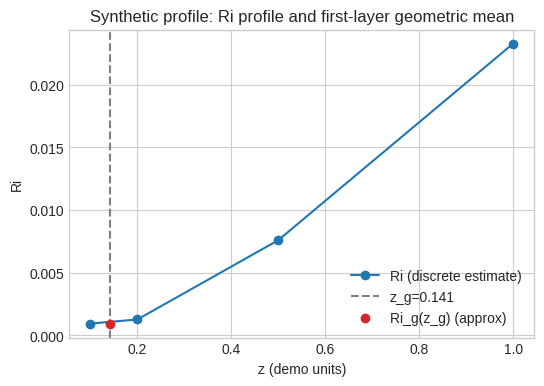

In [29]:
# Create a tiny synthetic NetCDF profile and run a simple Ri diagnostic
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt

# --- Synthetic profile (zeta-like heights for demo; units are demo units)
z = np.array([0.1, 0.2, 0.5, 1.0])   # simple vertical levels (can be interpreted as zeta)
kappa = 0.4
u_star = 0.25
z0 = 0.01

# Log-wind profile for U (real-like shape)
U = (u_star / kappa) * np.log(z / z0)

# Simple temperature profile: near-surface inversion (linear for demo)
theta0 = 280.0
Gamma = 0.5   # K per demo unit (strong near-surface gradient for demo)
theta = theta0 + Gamma * (z - z[0])

# Build xarray Dataset and write NetCDF to notebook folder
ds = xr.Dataset({'U': (('z',), U), 'theta': (('z',), theta)}, coords={'z': z})
nc_path = 'sample_profiles.nc'
ds.to_netcdf(nc_path)
print(f"Wrote synthetic NetCDF -> {nc_path} (z levels: {z.tolist()})")

# --- Read back and compute discrete Ri diagnostics
ds2 = xr.open_dataset(nc_path)
z = ds2['z'].values
U = ds2['U'].values
theta = ds2['theta'].values
g = 9.81

# Compute gradients (forward/backward where needed)
dU_dz = np.gradient(U, z)
dtheta_dz = np.gradient(theta, z)

# Point Ri_g at levels (use local theta value in denominator)
Ri_point = (g / theta) * (dtheta_dz / (dU_dz**2))

# First-layer bulk Ri_b between z[0] and z[1]
Delta_theta = theta[1] - theta[0]
Delta_U = U[1] - U[0]
Delta_z = z[1] - z[0]
theta_ref = 0.5 * (theta[0] + theta[1])
Ri_b = (g / theta_ref) * (Delta_theta * Delta_z) / (Delta_U**2)

# Geometric mean and approximate point Ri at z_g using layer-centered gradients
z_g = math.sqrt(z[0] * z[1])
# approximate gradient at first layer using forward difference already available
U_z_first = (U[1] - U[0]) / (z[1] - z[0])
theta_z_first = (theta[1] - theta[0]) / (z[1] - z[0])
theta_g = 0.5 * (theta[0] + theta[1])
Ri_g_zg = (g / theta_g) * (theta_z_first / (U_z_first**2))

# Bias ratio
B = Ri_g_zg / Ri_b if Ri_b != 0 else np.nan

print(f"First-layer z0={z[0]:.3f}, z1={z[1]:.3f}, z_g={z_g:.3f}")
print(f"Ri_g at z_g (approx) = {Ri_g_zg:.5f}")
print(f"Bulk Ri_b (layer) = {Ri_b:.5f}")
print(f"Bias ratio B = Ri_g(z_g)/Ri_b = {B:.3f}")

# --- Quick plot: Ri_point vs z and mark geometric mean
plt.figure(figsize=(6,4))
plt.plot(z, Ri_point, 'o-', label='Ri (discrete estimate)')
plt.axvline(z_g, color='gray', linestyle='--', label=f'z_g={z_g:.3f}')
plt.scatter([z_g], [Ri_g_zg], color='C3', zorder=10, label='Ri_g(z_g) (approx)')
plt.xlabel('z (demo units)')
plt.ylabel('Ri')
plt.title('Synthetic profile: Ri profile and first-layer geometric mean')
plt.legend()
plt.grid(True)
plt.show()

# Close dataset
ds2.close()